LQR Gain K = [-223.60679775  -12.06626771]


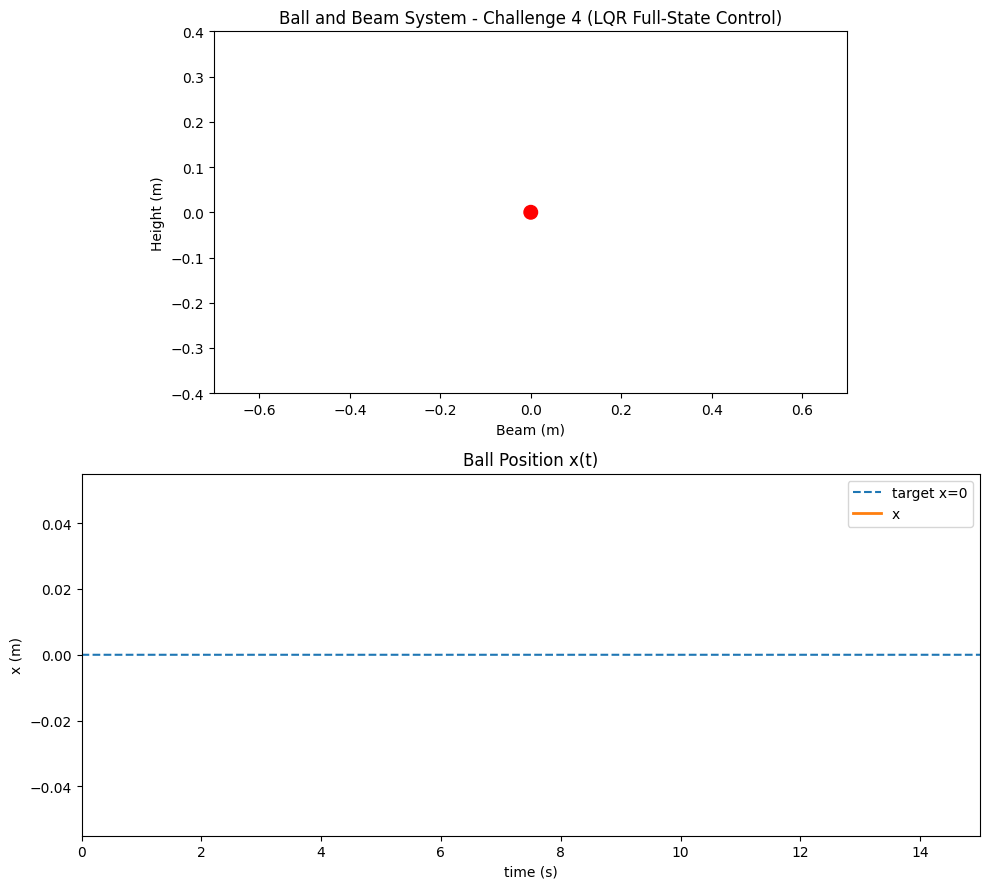

Final position: -1.072252649514837e-159


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, patches
from scipy.linalg import solve_continuous_are

# ==========================
# Parameters (from challenge)
# ==========================
g = 9.81
R = 0.02
L = 1.0
alpha = g / (1 + (2 * R * R) / (5 * L * L))

dt = 0.01
T = 15.0
steps = int(T / dt)

# ==========================
# Linearized Model
# ==========================
A = np.array([[0.0, 1.0],
              [0.0, 0.0]])

B = np.array([[0.0],
              [-alpha]])

C = np.array([[1.0, 0.0]])

# ==========================
# LQR DESIGN (Challenge 4)
# ==========================
Q = np.diag([500.0, 1.0])  # tune freely
R = np.array([[0.01]])     # penalize control effort

P = solve_continuous_are(A, B, Q, R)
K = (np.linalg.inv(R) @ B.T @ P).flatten()

print("LQR Gain K =", K)

u_max = 0.4   # actuator saturation

# ==========================
# Disturbance OFF (Challenge 4)
# ==========================
disturbance_enabled = False
disturbance_interval = 2.0
disturbance_duration = 2.0
disturbance_magnitude = 0.2

# ==========================
# Simulation storage
# ==========================
time = np.linspace(0, T, steps)
x_hist = np.zeros((steps, 2))
u_hist = np.zeros(steps)

rng = np.random.default_rng(12345)

# initial state
x = np.array([0.2, 0.0])

# ==========================
# Simulation Loop
# ==========================
for i in range(steps):
    t = i * dt

    x_hist[i] = x

    # FULL STATE FEEDBACK (Challenge 4)
    u = -K @ x
    u = float(np.clip(u, -u_max, u_max))
    u_hist[i] = u

    # disturbance (OFF)
    d = 0.0

    # system dynamics (linear or nonlinear allowed)
    xdot = A @ x + (B.flatten() * u) + np.array([0.0, d])
    x = x + xdot * dt

# ==========================
# Visualization Section
# ==========================
fig = plt.figure(figsize=(10, 9))

ax_anim = fig.add_subplot(2, 1, 1)
ax_pos = fig.add_subplot(2, 1, 2)

beam_len = L
ball_radius_vis = 0.015

ax_anim.set_xlim(-beam_len/2 - 0.2, beam_len/2 + 0.2)
ax_anim.set_ylim(-0.4, 0.4)
ax_anim.set_aspect('equal')
ax_anim.set_title("Ball and Beam System - Challenge 4 (LQR Full-State Control)")
ax_anim.set_xlabel("Beam (m)")
ax_anim.set_ylabel("Height (m)")

beam_line, = ax_anim.plot([], [], linewidth=3, color='black', zorder=1)
ball_patch = patches.Circle((0,0), ball_radius_vis, color='red', zorder=10)
ax_anim.add_patch(ball_patch)

timer_text = ax_anim.text(0.05, 0.85, "", transform=ax_anim.transAxes, fontsize=11)
timer_running = False
timer_value = 0.0
center_threshold = 0.05

ax_pos.set_title("Ball Position x(t)")
ax_pos.set_xlabel("time (s)")
ax_pos.set_ylabel("x (m)")

ax_pos.plot(time, np.zeros_like(time), '--', label="target x=0")
ax_pos.set_xlim(0, 15)

pos_line, = ax_pos.plot([], [], label="x", linewidth=2)
ax_pos.legend()

def beam_endpoints(angle):
    cx = 0.0
    dx = beam_len/2 * np.cos(angle)
    dy = beam_len/2 * np.sin(angle)
    return (cx-dx, -dy), (cx+dx, dy)

def init():
    beam_line.set_data([], [])
    ball_patch.center = (0,0)
    pos_line.set_data([], [])
    timer_text.set_text("")
    return beam_line, ball_patch, pos_line, timer_text

plot_time = []
plot_x = []

def animate(i):
    global timer_running, timer_value

    if timer_value >= 15.0:
        timer_value = 0.0
        timer_running = False
        plot_time.clear()
        plot_x.clear()
        ani.frame_seq = ani.new_frame_seq()  
        return init()  

    angle = u_hist[i]
    (x1,y1),(x2,y2) = beam_endpoints(angle)
    beam_line.set_data([x1,x2],[y1,y2])

    xb = x_hist[i,0]
    xb = np.clip(xb, -beam_len/2, beam_len/2)
    ball_patch.center = (xb*np.cos(angle), xb*np.sin(angle))

    if timer_running:
        plot_time.append(timer_value)
        plot_x.append(xb)

    pos_line.set_data(plot_time, plot_x)

    if abs(xb) < center_threshold:
        timer_running = True
    if timer_running:
        timer_value += 0.02
        timer_text.set_text(f"Time: {timer_value:.1f}s")

    return beam_line, ball_patch, pos_line, timer_text

ani = animation.FuncAnimation(
    fig, animate, frames=steps, init_func=init, interval=20, blit=True
)

plt.tight_layout()
plt.show()

print("Final position:", x_hist[-1,0])
